# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 0 (General) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [1]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

In [2]:
from os.path import exists
from os import makedirs

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm0'

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
else:
    makedirs(f'{LOG_PATH}/{METHOD_TAG}')
    print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m0



## Measuring Gradient Variance Decay

In [7]:
# Only use in the fist phase

num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [8]:
reps = num_qubits
ansatzes_m0 = [AnsatzGenerator(n, r) for n, r in zip(num_qubits, reps)]

In [9]:
def sampleM0Var():
    gradients_m0 = sampleAnsatz(estimator, ansatzes_m0, G_O)
    variance = getVariance(gradients_m0, num_qubits)
    return variance

## Loss Function Surface

In [10]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MAX_REPS, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)
initial_point = np.random.uniform(0, np.pi/2, ansatz.num_parameters)

In [11]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

# Force CPU - PyTorch+Qiskit too slow with GPU
devices = ('CPU')
devices

'CPU'

In [12]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    estimator = Estimator()
    estimator.set_options(method='statevector')
    estimator.set_options(device=device)
    estimator.set_options(seed=seed)
    estimator.options

print(f'Selected device: {device}')

Selected device: CPU


In [13]:
res = pd.DataFrame()
epochs = 200

start = time.time()
for i in range(0, epochs):
    print('iteration: ', i)
    display(res)
    pertubated_initial_point = initial_point + np.random.uniform(-0.1, 0.1, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=pertubated_initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)
elapsed = time.time() - start

pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration:  199


,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.078261,0.091547,1.339586,1.152947,0.864527,1.312867,1.350419,-0.038088,0.708502,0.024796,...,0.007523,0.317321,0.423176,0.042595,0.352363,1.393642,0.137190,1.131338,0.685672,1.005090
1,0.910224,-0.019868,1.325192,1.131061,0.937861,1.288437,1.295033,0.078218,0.641870,0.034812,...,0.130399,0.465718,0.466245,0.206404,0.319122,1.336145,0.029131,1.134305,0.659894,0.985250
2,1.032974,0.026477,1.162919,1.044141,0.853074,1.337584,1.437813,-0.043237,0.543107,0.079677,...,-0.002885,0.410788,0.489643,0.123573,0.387834,1.375233,0.007341,1.074224,0.626933,0.989847
3,0.935088,-0.029700,1.225248,1.130468,0.925995,1.457514,1.430750,0.072633,0.622444,0.038636,...,0.140849,0.358114,0.506081,0.153884,0.451197,1.288408,-0.009253,0.999127,0.546770,0.978062
4,1.030744,0.027687,1.300667,1.146748,0.846160,1.304681,1.447436,0.038938,0.726085,0.048651,...,0.153490,0.485754,0.532878,0.168914,0.427029,1.302081,0.133898,1.043846,0.697746,1.005858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.942279,0.073123,1.228163,1.198931,0.953369,1.353652,1.270807,0.077902,0.623976,0.023101,...,0.163459,0.352769,0.421066,0.084423,0.470159,1.311529,0.079191,1.154394,0.683474,0.993680
195,1.087324,0.027246,1.262052,1.063103,0.869998,1.450412,1.371597,0.075109,0.624263,0.028309,...,0.067827,0.442876,0.447940,0.107989,0.481202,1.408955,0.138729,1.103908,0.535116,0.994286
196,1.004270,-0.039445,1.251917,1.182343,0.806313,1.352443,1.285796,0.074941,0.657683,0.073248,...,0.046486,0.389790,0.495035,0.102452,0.379895,1.388978,0.083141,1.135232,0.543730,0.996851
197,1.066574,0.105232,1.332244,1.206365,0.918347,1.450035,1.419255,0.074349,0.672265,0.047912,...,0.068076,0.319245,0.435820,0.171072,0.322072,1.416587,0.155974,1.155188,0.619671,0.995218


In [14]:
# Print run statistics
print(f'{device} Fit\n'+
      f'\tQubits:\t\t{num_qubits}\n'+
      f'\tReps:\t\t{reps}\n'+
      f'\tWeights:\t{len(ansatz.parameters)}\n'+
      f'\tEpochs:\t\t{epochs})\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec')

CPU Fit
	Qubits:		[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Reps:		[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Weights:	104
	Epochs:		200)
	Time:		598.15 sec


## Measure Training Performance

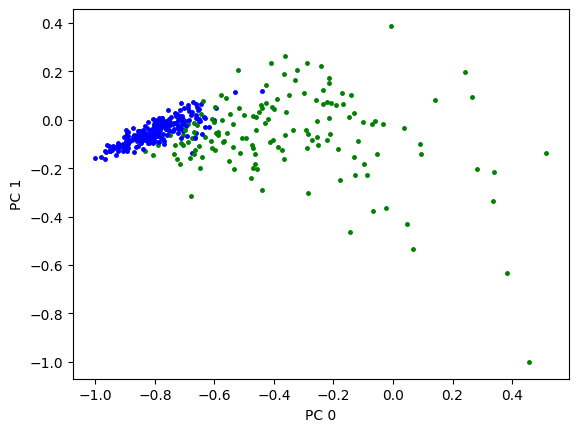

Blue: torch.Size([250])
Green: torch.Size([148])


In [15]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

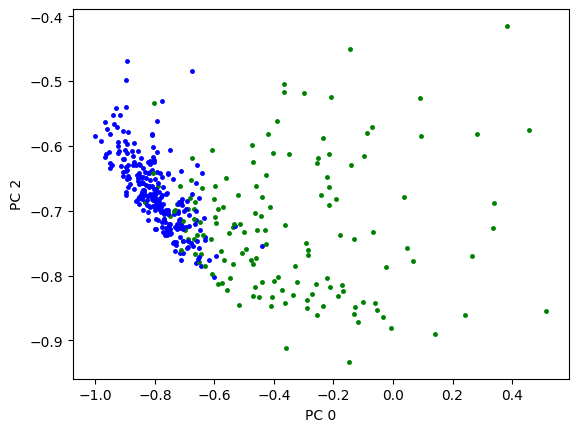

Blue: torch.Size([250])
Green: torch.Size([148])


In [16]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [17]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MAX_REPS, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)

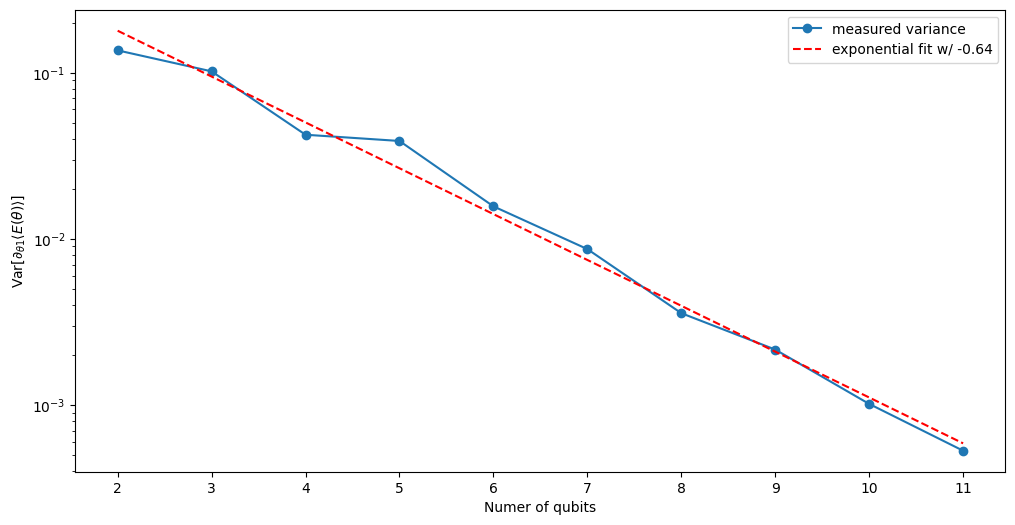

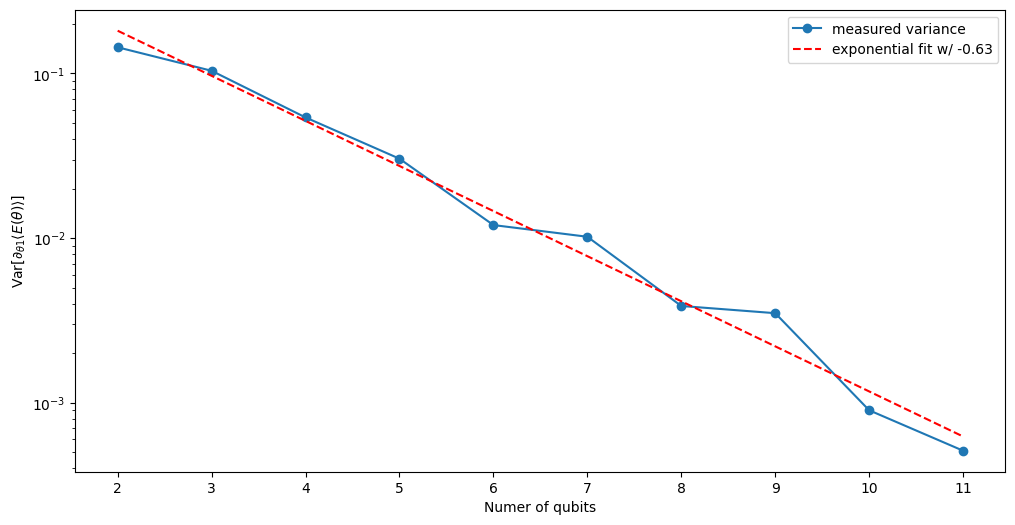

In [18]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH
times = []

# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
for i in [4, 5]: 
     
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')

    m0_variances = sampleM0Var()
        
    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    # By default random initialisation
    model = TorchConnector(qnn)

    loss_function = nn.L1Loss() # nn.MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    start = time.time()
    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    elapsed = time.time() - start
    times.append(elapsed)

    pd.DataFrame(m0_variances, num_qubits).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Variances.csv')
    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)


In [19]:
print(f'\nAverage time / instance: {np.average(times)}')


Average time / instance: 38970.092802882195


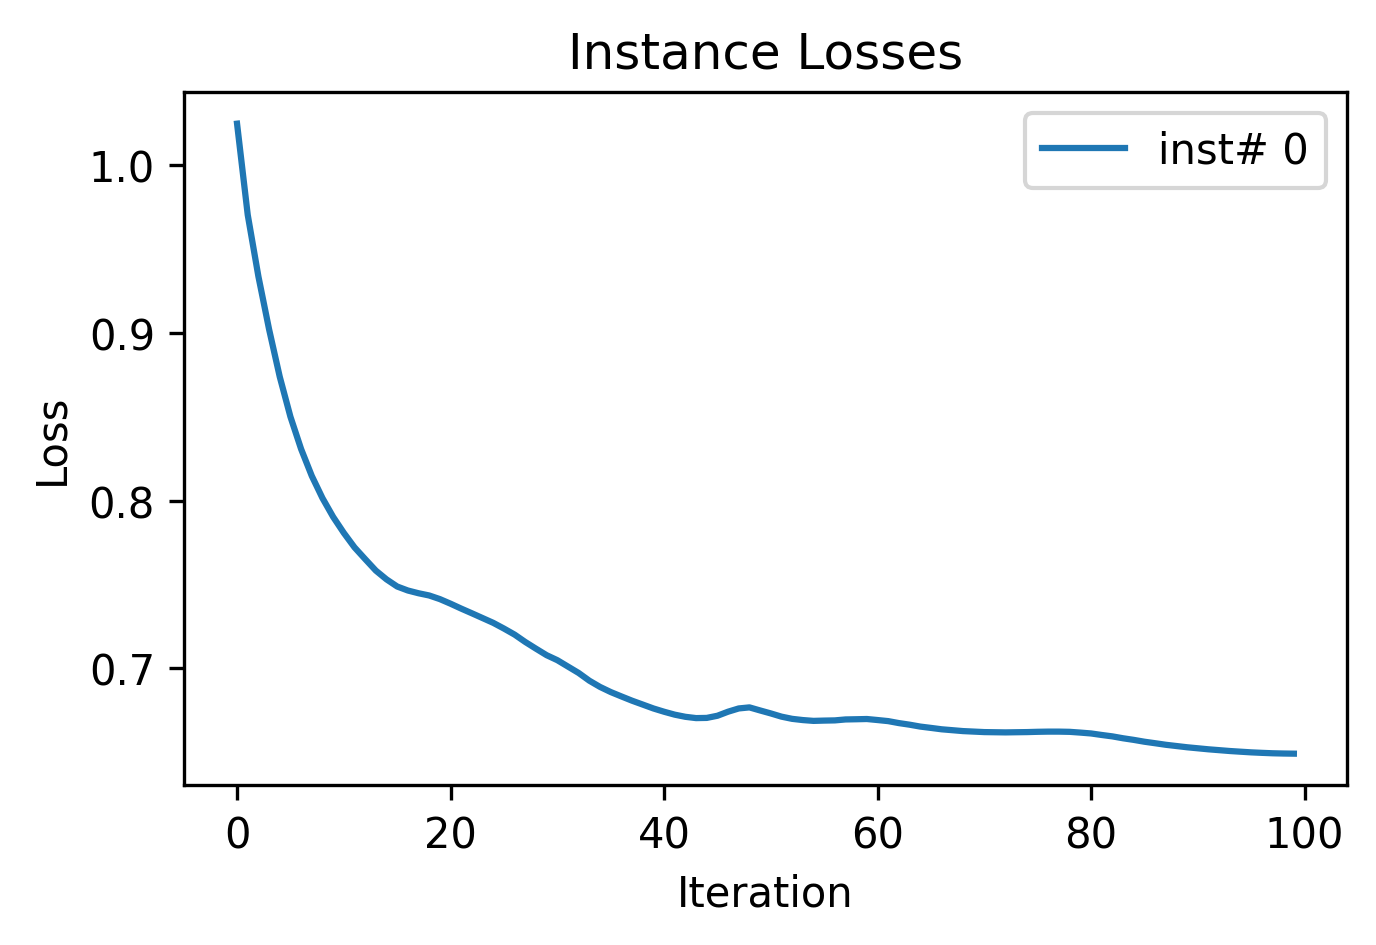

In [20]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

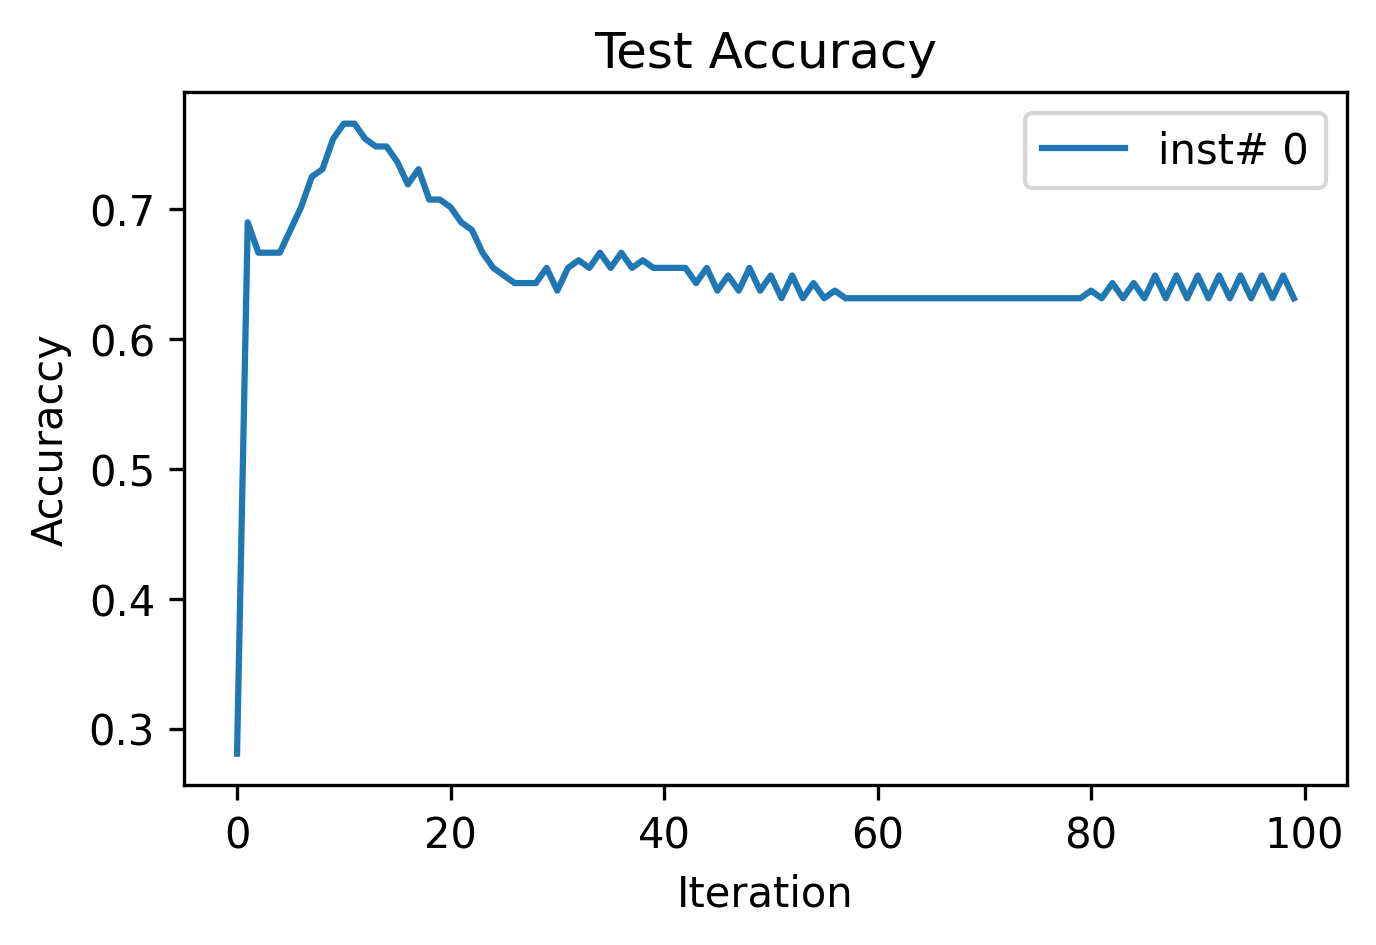

In [21]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [22]:
!pip list | grep qiskit

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2


In [23]:
!pip list | grep torch

torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
